<a href="https://colab.research.google.com/github/nullbringer/deeplab/blob/master/project2_ref.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Lambda, Activation, Concatenate, Add, Dropout
from tensorflow.python.keras.layers import BatchNormalization, Conv2D, DepthwiseConv2D, ZeroPadding2D
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import SGD

In [0]:
import h5py
import numpy as np
import random
import cv2

from keras.preprocessing.image import ImageDataGenerator

# Use only 3 classes.
# labels = ['background', 'person', 'car', 'road']


def pre_processing(img):
    # Random exposure and saturation (0.9 ~ 1.1 scale)
    rand_s = random.uniform(0.9, 1.1)
    rand_v = random.uniform(0.9, 1.1)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    tmp = np.ones_like(img[:, :, 1]) * 255
    img[:, :, 1] = np.where(img[:, :, 1] * rand_s > 255, tmp, img[:, :, 1] * rand_s)
    img[:, :, 2] = np.where(img[:, :, 2] * rand_v > 255, tmp, img[:, :, 2] * rand_v)

    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    # Centering helps normalization image (-1 ~ 1 value)
    return img / 127.5 - 1


# Get ImageDataGenerator arguments(options) depends on mode - (train, val, test)
def get_data_gen_args(mode):
    if mode == 'train' or mode == 'val':
        x_data_gen_args = dict(preprocessing_function=pre_processing,
                               shear_range=0.1,
                               zoom_range=0.1,
                               rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               fill_mode='constant',
                               horizontal_flip=True)

        y_data_gen_args = dict(shear_range=0.1,
                               zoom_range=0.1,
                               rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               fill_mode='constant',
                               horizontal_flip=True)

    elif mode == 'test':
        x_data_gen_args = dict(preprocessing_function=pre_processing)
        y_data_gen_args = dict()

    else:
        print("Data_generator function should get mode arg 'train' or 'val' or 'test'.")
        return -1

    return x_data_gen_args, y_data_gen_args


# One hot encoding for y_img.
def get_result_map(b_size, y_img):
    y_img = np.squeeze(y_img, axis=3)
    result_map = np.zeros((b_size, 256, 512, 4))

    # For np.where calculation.
    person = (y_img == 24)
    car = (y_img == 26)
    road = (y_img == 7)
    background = np.logical_not(person + car + road)

    result_map[:, :, :, 0] = np.where(background, 1, 0)
    result_map[:, :, :, 1] = np.where(person, 1, 0)
    result_map[:, :, :, 2] = np.where(car, 1, 0)
    result_map[:, :, :, 3] = np.where(road, 1, 0)

    return result_map


# Data generator for fit_generator.
def data_generator(d_path, b_size, mode):
    data = h5py.File(d_path, 'r')
    x_imgs = data.get('/' + mode + '/x')
    y_imgs = data.get('/' + mode + '/y')

    # Make ImageDataGenerator.
    x_data_gen_args, y_data_gen_args = get_data_gen_args(mode)
    x_data_gen = ImageDataGenerator(**x_data_gen_args)
    y_data_gen = ImageDataGenerator(**y_data_gen_args)

    # random index for random data access.
    d_size = x_imgs.shape[0]
    shuffled_idx = list(range(d_size))

    x = []
    y = []
    while True:
        random.shuffle(shuffled_idx)
        for i in range(d_size):
            idx = shuffled_idx[i]

            x.append(x_imgs[idx].reshape((256, 512, 3)))
            y.append(y_imgs[idx].reshape((256, 512, 1)))

            if len(x) == b_size:
                # Adapt ImageDataGenerator flow method for data augmentation.
                _ = np.zeros(b_size)
                seed = random.randrange(1, 1000)

                x_tmp_gen = x_data_gen.flow(np.array(x), _,
                                            batch_size=b_size,
                                            seed=seed)
                y_tmp_gen = y_data_gen.flow(np.array(y), _,
                                            batch_size=b_size,
                                            seed=seed)

                # Finally, yield x, y data.
                x_result, _ = next(x_tmp_gen)
                y_result, _ = next(y_tmp_gen)

                yield x_result, get_result_map(b_size, y_result)

                x.clear()
                y.clear()

In [0]:
def relu6(x):
    return relu(x, max_value=6)


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1].value  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='cityscapes', input_tensor=None, input_shape=(512, 512, 3), classes=19, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """ Instantiates the Deeplabv3+ architecture

    Optionally loads weights pre-trained
    on PASCAL VOC or Cityscapes. This model is available for TensorFlow only.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images. None is allowed as shape/width
        classes: number of desired classes. PASCAL VOC has 21 classes, Cityscapes has 19 classes.
            If number of classes not aligned with the weights used, last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone. Pretrained is only available for alpha=1.

    # Returns
        A Keras model instance.

    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`

    """


    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor


    OS = 8
    first_block_filters = _make_divisible(32 * alpha, 8)
    x = Conv2D(first_block_filters,
                kernel_size=3,
                strides=(2, 2), padding='same',
                use_bias=False, name='Conv')(img_input)
    x = BatchNormalization(
        epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
    x = Activation(relu6, name='Conv_Relu6')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0, skip_connection=False)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1, skip_connection=False)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2, skip_connection=True)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3, skip_connection=False)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4, skip_connection=True)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5, skip_connection=True)

    # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                            expansion=6, block_id=6, skip_connection=False)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=7, skip_connection=True)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=8, skip_connection=True)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=9, skip_connection=True)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=10, skip_connection=False)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=11, skip_connection=True)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=12, skip_connection=True)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                            expansion=6, block_id=13, skip_connection=False)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=14, skip_connection=True)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=15, skip_connection=True)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3],
                                                    method='bilinear', align_corners=True))(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    last_layer_name = 'logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                    size_before3[1:3],
                                                    method='bilinear', align_corners=True))(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    model = Model(inputs, x, name='deeplabv3plus')

    model.load_weights('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5', by_name=True)
    return model

def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return preprocess_input(x, mode='tf')


In [123]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt


# Generates labels using most basic setup.  Supports various image sizes.  Returns image labels in same format
# as original image.  Normalization matches MobileNetV2

trained_image_width=512
trained_image_height=256 
mean_subtraction_value=127.5
image = np.array(Image.open('m1.png'))

# resize to max dimension of images from training dataset
w, h, _ = image.shape
ratio = float(trained_image_width) / np.max([w, h])
resized_image = np.array(Image.fromarray(image.astype('uint8')).resize((int(ratio * h), int(ratio * w))))

# apply normalization for trained dataset images
resized_image = (resized_image / mean_subtraction_value) - 1.

print(resized_image.shape)

# pad array to square image to match training images
pad_x = int(trained_image_height - resized_image.shape[0])
pad_y = int(trained_image_width - resized_image.shape[1])
# resized_image = np.pad(resized_image, ((0, pad_x), (0, pad_y), (0, 0)), mode='constant')





(256, 512, 3)


In [0]:
# make prediction
deeplab_model = Deeplabv3(input_shape=(256, 512, 3))


In [0]:
# deeplab_model.compile(optimizer=SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True),
                  # loss='categorical_crossentropy')

In [0]:
# TRAIN_BATCH =5
# VAL_BATCH = 2

# history = deeplab_model.fit_generator(data_generator('data.h5', TRAIN_BATCH, 'train'),
#                               steps_per_epoch=100 // TRAIN_BATCH,
#                               validation_data=data_generator('data.h5', VAL_BATCH, 'val'),
#                               validation_steps=50 // VAL_BATCH,
#                               epochs=100,
#                               verbose=1)

In [0]:
res = deeplab_model.predict(np.expand_dims(resized_image, 0))
labels = np.argmax(res.squeeze(), -1)

In [121]:
resized_image.shape

(256, 512, 3)

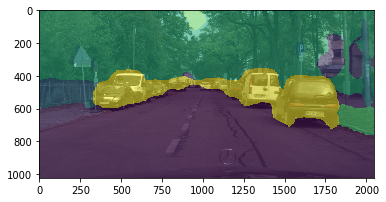

In [126]:
# remove padding and resize back to original image
if pad_x > 0:
    labels = labels[:-pad_x]
if pad_y > 0:
    labels = labels[:, :-pad_y]
labels = np.array(Image.fromarray(labels.astype('uint8')).resize((h, w)))

plt.imshow(labels,interpolation='none') 
plt.imshow(image, cmap='jet', interpolation='none', alpha=0.5)
# plt.waitforbuttonpress()


In [90]:
labels.shape

(512, 512)